<h1>Clustering Neighborhoods in Rome<h1>

<h2>Table of Contents<h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 4>

1. <a href="#item1">Business Problem</a>

2. <a href="#item2">Data Description</a>

3. <a href="#item3">Methodology</a>

3. <a href="#item4">Analysis</a>

4. <a href="#item5">Discussion and Results</a>

5. <a href="#item6">Conclusion</a>    
</font>
</div>

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1=mpimg.imread('Neighb_coord.png')
img2=mpimg.imread('Neighb_most_common_venues.png')

<a id='item1'></a>

## 1. Business Problem

**Rome** is the capital city of **Italy**. With a population of almost **3 million** inhabitants, it is the biggest city in the country and in the last few decades, it has been attracting people both from the rest of Italy and from abroad. 

Because of this, Rome has become a very complex city. It comprizes **35 neighborhoods** which are very different from each other, therefore it can be quite challenging for somebody who wants to move to Rome to decide in which neighborhood to move or for an entrepreneur to find out what could be the best part of the city where to start their business.

This project wants to provide some help in answering these questions. It aims to do this by dividing Rome's neighborhoods into **5 clusters** after determining the most common venues for each neighborhood.

The results can be interesting for **Rome's local government** in order to provide new **potential citizens or entrepreneurs** with the information which they will possibly need before moving to the Eternal City or starting an economic activity there.

<a id='item2'></a>

## 2. Data Description

I mainly used two data sources:

1. I created an **xsl file** with a table providing information about each neighborhood in Rome. In each row of the table, you can find the neighborhood's **number** (from 1 to 35), its **name** (e. g. "Parioli") and its **geographical coordinates** (latitude and longitude). Since I was not able to find a dataframe containing the geographical coordinates of each neighborhood, I visited the **Wikipedia** page https://it.wikipedia.org/wiki/Quartieri_di_Roma. There, I found a list of all the neighborhoods and by clicking on the neighborhood's name, I found its geographical coordinates in decimal form reported on the upper right side of the page. By copying this data for each neighborhood, I was finally able to create an xsl that I could import on my Jupyter notebook and turn into a dataframe:

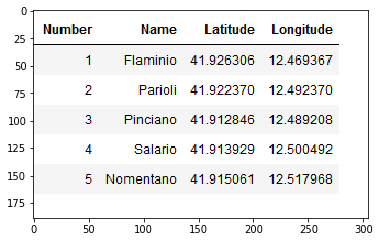

In [22]:
plt1 = plt.imshow(img1) 

2. I used the **Foursquare API** to find out the 10 most common venues for each neighborhood. Through the Foursquare API, it is possible to extract from the data particular information which we are interested in. For example, I was interested in the type of the most common venues, so I created a dataframe reporting these data. Here is what the dataframe looks like:

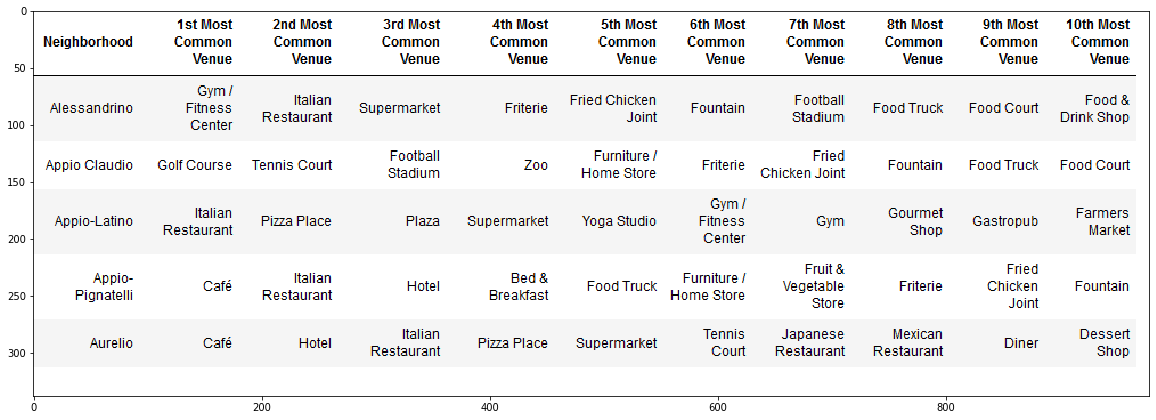

In [29]:
plt.figure(figsize=(20, 30))
plt2 = plt.imshow(img2)

<a id='item3'></a>

## 3. Methodology

<a id='item4'></a>

## 4. Analysis

First of all, we will import all the necessary libraries.

In [143]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import the library we use to open URLs
import urllib.request

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # transform JSON file into a pandas dataframe 

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

! pip install folium
import folium

print('Libraries imported!')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported!


Since no table containing data about the geographical coordinates of Rome's neighborhoods was available, I created an Excel file and manually enetered the data which I found on the following Wikipedia page: https://it.wikipedia.org/wiki/Quartieri_di_Roma.

By clicking on the name of every neighborhood, a new window shows their geographical coordinates. I copied and pasted each one of them in the Excel file which we will now import in our notebook.

As we can see below, the Excel file contains each neighborhood's number, name, latitude and longitude.

In [144]:
df = pd.read_excel (r'C:\Users\falni\Desktop\Coursera\IBM Data Science Professional Certificate\Labs\Final Assignment 9\Rome_neighb.xlsx')
df.head()

,Number,Name,Latitude,Longitude
0,1,Flaminio,41.926306,12.469367
1,2,Parioli,41.922370,12.492370
2,3,Pinciano,41.912846,12.489208
3,4,Salario,41.913929,12.500492
4,5,Nomentano,41.915061,12.517968


Now we're ready to explore the dataset. We use the geopy library to get the latitude and longitude values of Rome.

In [145]:
address = 'Rome'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Milan are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Milan are 41.8933203, 12.4829321.


Now we want to create a map of Rome's neighborhoods.

In [146]:
map_rome = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for num, name, lat, lng in zip(df['Number'], df['Name'], df['Latitude'], df['Longitude']):
    label = '{}: {}'.format(num, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rome)  
    
map_rome 

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them. First, we define the Foursquare Credentials and Version.

In [147]:
CLIENT_ID = 'TLIHYDEOP51XCTHFTDINAAYTONTLGSM0RBE0DDU0340BIT11' # your Foursquare ID
CLIENT_SECRET = 'GAMU2WXV4I3PFWGUWPQ3YEVE2KDHP2YI15TU3AEDLIM1XJ32' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TLIHYDEOP51XCTHFTDINAAYTONTLGSM0RBE0DDU0340BIT11
CLIENT_SECRET:GAMU2WXV4I3PFWGUWPQ3YEVE2KDHP2YI15TU3AEDLIM1XJ32


Now we want to explore the first neighborhood in our dataframe. Let's get its name!

In [148]:
print('Neighborhood 1 is called',df['Name'][0],'.')

Neighborhood 1 is called Flaminio .


Let's get the neighborhood's latitude and longitude values.

In [149]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Flaminio are 41.926306, 12.469367.


Now, let's get the top 100 venues that are in Flaminio within a radius of 500 meters.

First, let's create the GET request URL.

In [150]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=TLIHYDEOP51XCTHFTDINAAYTONTLGSM0RBE0DDU0340BIT11&client_secret=GAMU2WXV4I3PFWGUWPQ3YEVE2KDHP2YI15TU3AEDLIM1XJ32&ll=41.926306,12.469367&v=20180605&radius=500&limit=100'

In [151]:
results = requests.get(url).json()
#results

We know that all the information is in the items key. Before we proceed, let's create the get_category_type function to extract the categories of the venues.

In [152]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [153]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\falni\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,20MQ Design e Caffè,Café,41.925191,12.470467
1,Tiepolo,Diner,41.924321,12.469223
2,MAXXI Museo Nazionale delle Arti del XXI Secolo,Art Museum,41.928455,12.466840
3,Hotel Butterfly,Restaurant,41.927151,12.467478
4,TreeBar,Cocktail Bar,41.923152,12.471377


Let's create a function to repeat the same process to all the neighborhoods in Rome.

In [154]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we will write the code to run the above function on each neighborhood and create a new dataframe called rome_venues.

In [155]:
rome_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']

                             ) 
print('The dataframe has',rome_venues.shape[0],'rows.')
rome_venues.head()

Flaminio
Parioli
Pinciano
Salario
Nomentano
Tiburtino
Prenestino-Labicano
Tuscolano
Appio-Latino
Ostiense
Portuense
Gianicolense
Aurelio
Trionfale
Della Vittoria
Monte Sacro
Trieste
Tor di Quinto
Prenestino-Centocelle
Ardeatino
Pietralata
Collatino
Alessandrino
Don Bosco
Appio Claudio
Appio-Pignatelli
Primavalle
Monte Sacro Alto
Ponte Mammolo
San Basilio
Giuliano-Dalmata
Europa
Lido di Ostia Ponente
Lido di Ostia Levante
Lido di Castel Fusano
The dataframe has 614 rows.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Flaminio,41.926306,12.469367,20MQ Design e Caffè,41.925191,12.470467,Café
1,Flaminio,41.926306,12.469367,Tiepolo,41.924321,12.469223,Diner
2,Flaminio,41.926306,12.469367,MAXXI Museo Nazionale delle Arti del XXI Secolo,41.928455,12.466840,Art Museum
3,Flaminio,41.926306,12.469367,Hotel Butterfly,41.927151,12.467478,Restaurant
4,Flaminio,41.926306,12.469367,TreeBar,41.923152,12.471377,Cocktail Bar


Let's check how many venues were returned for each neighborhood.

In [156]:
rome_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alessandrino,5,5,5,5,5,5
Appio Claudio,3,3,3,3,3,3
Appio-Latino,24,24,24,24,24,24
Appio-Pignatelli,4,4,4,4,4,4
Aurelio,23,23,23,23,23,23
Collatino,4,4,4,4,4,4
Della Vittoria,25,25,25,25,25,25
Don Bosco,33,33,33,33,33,33
Europa,42,42,42,42,42,42


Let's find out how many unique categories can be curated from all the returned venues.

In [157]:
print('There are {} uniques categories.'.format(len(rome_venues['Venue Category'].unique())))

There are 138 uniques categories.


In [158]:
# one hot encoding
rome_onehot = pd.get_dummies(rome_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rome_onehot['Neighborhood'] = rome_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rome_onehot.columns[-1]] + list(rome_onehot.columns[:-1])
rome_onehot = rome_onehot[fixed_columns]

rome_onehot.head()

,Neighborhood,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,...,Train Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Flaminio,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Flaminio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [159]:
print('The dataframe has',rome_onehot.shape[0],'rows and',rome_onehot.shape[1],'columns.')

The dataframe has 614 rows and 139 columns.


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [160]:
rome_grouped = rome_onehot.groupby('Neighborhood').mean().reset_index()
rome_grouped

,Neighborhood,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,...,Train Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo
0,Alessandrino,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Appio Claudio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Appio-Latino,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,...,0.0000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000
3,Appio-Pignatelli,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.00,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Aurelio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,...,0.0000,0.043478,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000
5,Collatino,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Della Vittoria,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.04,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Don Bosco,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.00,0.00,...,0.0000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Europa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Flaminio,0.032258,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.00,0.00,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let's confirm the new size.

In [161]:
print('This dataframe has',rome_grouped.shape[0],'rows and',rome_grouped.shape[1],'columns.')

This dataframe has 33 rows and 139 columns.


Let's print each neighborhood along with the top 5 most common venues.

In [162]:
num_top_venues = 5

for hood in rome_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp =rome_grouped[rome_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alessandrino----
                  venue  freq
0    Italian Restaurant   0.4
1  Gym / Fitness Center   0.4
2           Supermarket   0.2
3          Perfume Shop   0.0
4          Noodle House   0.0


----Appio Claudio----
              venue  freq
0       Golf Course  0.33
1      Tennis Court  0.33
2  Football Stadium  0.33
3      Perfume Shop  0.00
4            Office  0.00


----Appio-Latino----
                venue  freq
0         Pizza Place  0.17
1  Italian Restaurant  0.17
2               Plaza  0.04
3        Gourmet Shop  0.04
4                 Gym  0.04


----Appio-Pignatelli----
                venue  freq
0               Hotel  0.25
1  Italian Restaurant  0.25
2     Bed & Breakfast  0.25
3                Café  0.25
4          Playground  0.00


----Aurelio----
                venue  freq
0                Café  0.17
1  Italian Restaurant  0.09
2         Supermarket  0.09
3         Pizza Place  0.09
4               Hotel  0.09


----Collatino----
            venue  freq
0  

Let's put that into a pandas dataframe!

First, let's write a function to sort the venues in descending order.

In [176]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [177]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rome_grouped['Neighborhood']

for ind in np.arange(rome_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rome_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alessandrino,Gym / Fitness Center,Italian Restaurant,Supermarket,Friterie,Fried Chicken Joint,Fountain,Football Stadium,Food Truck,Food Court,Food & Drink Shop
1,Appio Claudio,Golf Course,Tennis Court,Football Stadium,Zoo,Furniture / Home Store,Friterie,Fried Chicken Joint,Fountain,Food Truck,Food Court
2,Appio-Latino,Italian Restaurant,Pizza Place,Plaza,Supermarket,Yoga Studio,Gym / Fitness Center,Gym,Gourmet Shop,Gastropub,Farmers Market
3,Appio-Pignatelli,Café,Italian Restaurant,Hotel,Bed & Breakfast,Food Truck,Furniture / Home Store,Fruit & Vegetable Store,Friterie,Fried Chicken Joint,Fountain
4,Aurelio,Café,Hotel,Italian Restaurant,Pizza Place,Supermarket,Tennis Court,Japanese Restaurant,Mexican Restaurant,Diner,Dessert Shop


Now we want to run k-means in order to divide our neighborhoods into k different clusters. However, we still don't know what the best value of k is, so let's apply the elbow method to find it out!

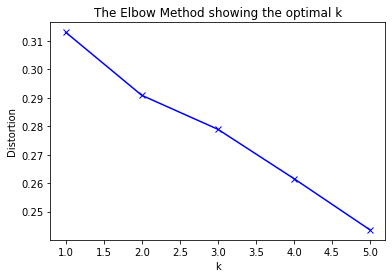

In [178]:
rome_grouped_clustering = rome_grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(rome_grouped_clustering)
    kmeanModel.fit(rome_grouped_clustering)
    distortions.append(sum(np.min(cdist(rome_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / rome_grouped_clustering.shape[0])
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Since the distortion value does not significantly slow down, as we can see from the plot, we will choose k=5, where the distortion is minimal.

In [179]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rome_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 4, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1,
       3, 0, 2, 3, 0, 3, 2, 0, 0, 2, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [180]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

rome_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
rome_merged = rome_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

rome_merged.head() # check the last columns!

,Number,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Flaminio,41.926306,12.469367,0.0,Italian Restaurant,Café,Diner,Pizza Place,Hotel,Pool,Restaurant,Art Museum,Paper / Office Supplies Store,Dance Studio
1,2,Parioli,41.922370,12.492370,0.0,Electronics Store,Italian Restaurant,Diner,Restaurant,Seafood Restaurant,Science Museum,Tea Room,Sandwich Place,Roman Restaurant,College Cafeteria
2,3,Pinciano,41.912846,12.489208,0.0,Italian Restaurant,Hotel,Art Museum,Plaza,Park,Nightclub,Museum,Movie Theater,Historic Site,Gym
3,4,Salario,41.913929,12.500492,0.0,Italian Restaurant,Café,Pizza Place,Ice Cream Shop,Pub,Dessert Shop,Chinese Restaurant,Juice Bar,Plaza,Art Museum
4,5,Nomentano,41.915061,12.517968,0.0,Hotel,Winery,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Trattoria/Osteria,Café,Art Museum,Park,Seafood Restaurant


Since we have no values for the neighborhoods Giuliano Dalmata and Ardeatino, we will drop those two rows.

In [181]:
rome_merged.dropna(inplace=True)
rome_merged.head()

,Number,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Flaminio,41.926306,12.469367,0.0,Italian Restaurant,Café,Diner,Pizza Place,Hotel,Pool,Restaurant,Art Museum,Paper / Office Supplies Store,Dance Studio
1,2,Parioli,41.922370,12.492370,0.0,Electronics Store,Italian Restaurant,Diner,Restaurant,Seafood Restaurant,Science Museum,Tea Room,Sandwich Place,Roman Restaurant,College Cafeteria
2,3,Pinciano,41.912846,12.489208,0.0,Italian Restaurant,Hotel,Art Museum,Plaza,Park,Nightclub,Museum,Movie Theater,Historic Site,Gym
3,4,Salario,41.913929,12.500492,0.0,Italian Restaurant,Café,Pizza Place,Ice Cream Shop,Pub,Dessert Shop,Chinese Restaurant,Juice Bar,Plaza,Art Museum
4,5,Nomentano,41.915061,12.517968,0.0,Hotel,Winery,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Trattoria/Osteria,Café,Art Museum,Park,Seafood Restaurant


Finally, let's visualize the resulting clusters!

In [182]:
rome_merged['Cluster Labels'] = rome_merged['Cluster Labels'].astype(int)
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rome_merged['Latitude'], rome_merged['Longitude'], rome_merged['Name'], rome_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we will assign a name to each cluster.

<h3>Cluster 1<h3>

In [183]:
rome_merged.loc[rome_merged['Cluster Labels'] == 0, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Flaminio,Italian Restaurant,Café,Diner,Pizza Place,Hotel,Pool,Restaurant,Art Museum,Paper / Office Supplies Store,Dance Studio
1,Parioli,Electronics Store,Italian Restaurant,Diner,Restaurant,Seafood Restaurant,Science Museum,Tea Room,Sandwich Place,Roman Restaurant,College Cafeteria
2,Pinciano,Italian Restaurant,Hotel,Art Museum,Plaza,Park,Nightclub,Museum,Movie Theater,Historic Site,Gym
3,Salario,Italian Restaurant,Café,Pizza Place,Ice Cream Shop,Pub,Dessert Shop,Chinese Restaurant,Juice Bar,Plaza,Art Museum
4,Nomentano,Hotel,Winery,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Trattoria/Osteria,Café,Art Museum,Park,Seafood Restaurant
7,Tuscolano,Kebab Restaurant,Chinese Restaurant,Japanese Restaurant,Hotel,Martial Arts Dojo,Fried Chicken Joint,Fast Food Restaurant,Pizza Place,Restaurant,Sandwich Place
9,Ostiense,Nightclub,Italian Restaurant,Pub,Café,Restaurant,Gastropub,Gym,Park,Electronics Store,Speakeasy
14,Della Vittoria,Stadium,Soccer Field,Tennis Court,Nightclub,Soccer Stadium,Music Venue,Pool,Event Space,Beer Garden,Tennis Stadium
15,Monte Sacro,Chinese Restaurant,Wine Shop,Plaza,Italian Restaurant,Sandwich Place,Japanese Restaurant,BBQ Joint,Pizza Place,Café,Seafood Restaurant
16,Trieste,Café,Dessert Shop,Ice Cream Shop,Plaza,Italian Restaurant,Supermarket,Movie Theater,Burger Joint,Pizza Place,Diner


<h3>Cluster 2<h3>

In [184]:
rome_merged.loc[rome_merged['Cluster Labels'] == 1, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Ponte Mammolo,Asian Restaurant,Furniture / Home Store,Zoo,Food Truck,Fruit & Vegetable Store,Friterie,Fried Chicken Joint,Fountain,Football Stadium,Food Court


<h3>Cluster 3<h3>

In [185]:
rome_merged.loc[rome_merged['Cluster Labels'] == 2, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Tiburtino,Supermarket,Pharmacy,Clothing Store,Paper / Office Supplies Store,Music Venue,Football Stadium,Fruit & Vegetable Store,Friterie,Fried Chicken Joint,Fountain
6,Prenestino-Labicano,Italian Restaurant,Pizza Place,Bar,Sandwich Place,Plaza,Brewery,Light Rail Station,Greek Restaurant,Gastropub,Office
8,Appio-Latino,Italian Restaurant,Pizza Place,Plaza,Supermarket,Yoga Studio,Gym / Fitness Center,Gym,Gourmet Shop,Gastropub,Farmers Market
11,Gianicolense,Pizza Place,Italian Restaurant,Ice Cream Shop,Plaza,Café,Supermarket,Dessert Shop,Indian Restaurant,Pub,Sandwich Place
12,Aurelio,Café,Hotel,Italian Restaurant,Pizza Place,Supermarket,Tennis Court,Japanese Restaurant,Mexican Restaurant,Diner,Dessert Shop
13,Trionfale,Hotel,Pizza Place,Italian Restaurant,Train Station,Shoe Store,Coffee Shop,Supermarket,Gym / Fitness Center,Gym,Plaza
20,Pietralata,Metro Station,Pizza Place,Hotel,Supermarket,Shopping Mall,Gym,Park,Zoo,Food Court,Fountain
21,Collatino,Plaza,Supermarket,Café,Cosmetics Shop,Food Truck,Fruit & Vegetable Store,Friterie,Fried Chicken Joint,Fountain,Football Stadium
22,Alessandrino,Gym / Fitness Center,Italian Restaurant,Supermarket,Friterie,Fried Chicken Joint,Fountain,Football Stadium,Food Truck,Food Court,Food & Drink Shop
25,Appio-Pignatelli,Café,Italian Restaurant,Hotel,Bed & Breakfast,Food Truck,Furniture / Home Store,Fruit & Vegetable Store,Friterie,Fried Chicken Joint,Fountain


<h3>Cluster 4<h3>

In [186]:
rome_merged.loc[rome_merged['Cluster Labels'] == 3, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Portuense,Pizza Place,Fruit & Vegetable Store,Gym / Fitness Center,Café,Sushi Restaurant,Friterie,Fried Chicken Joint,Fountain,Football Stadium,Food Truck
26,Primavalle,Pizza Place,Chinese Restaurant,Clothing Store,Movie Theater,Peruvian Restaurant,Perfume Shop,Food & Drink Shop,Café,Gym,Fountain
29,San Basilio,Dessert Shop,Pizza Place,Restaurant,Pharmacy,Zoo,Food & Drink Shop,Fried Chicken Joint,Fountain,Football Stadium,Food Truck


<h3>Cluster 5<h3>

In [187]:
rome_merged.loc[rome_merged['Cluster Labels'] == 4, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Appio Claudio,Golf Course,Tennis Court,Football Stadium,Zoo,Furniture / Home Store,Friterie,Fried Chicken Joint,Fountain,Food Truck,Food Court


<a id='item5'></a>

## 5. Discussion and Results

<a id='item6'></a>

## 6. Conclusion